Problem Set 4: Group 8 

# Excercise 1 

### Aim:  
Compare the coverage probabilities of analytical and bootstrapped confidence intervals

###### Motivation: 

The traditional approach for statistical inference relies on drawing one sample of size n from the population and use that sample to calculate population estimates.

With bootstrap we resample from the original sample (under the assumption it is representative of the population) to get an idea 
for the range of values our estimate can take. From the estimated distribution we can calculate standard errors and construct confidence intervals for a variety of estimators

#### Data Generating Process
- $y_i = ß_1 + ß_2x_i +ß_3x^2_i + ß_4x^3_i+ ß_5x^4_i + e$
where

- $X \sim N(0,1) $
- $e \sim N(0,1) $
- $ß = (1 , 1.5 , -1.5 , 1.5 ,  0.5) $
- $n = 200$


In [16]:
rm(list=ls())
library(boot)
library(ggplot2)

set.seed(8)
beta = c(1,1.5,-1.5,1.5,0.5)
n=200


DGP <- function(n, beta){
    X <-rnorm(n,sd=1)
  XX <- cbind( rep(1,n),X,X^2,X^3,X^4)
  
  error <- rnorm(n,sd=1) # error terms
  Y <- XX%*%beta+error
  data <- data.frame("Y"=Y,"int"=XX[,1],"X"=XX[,2],"X.2"=XX[,3],"X.3"=XX[,4],"X.4"=XX[,5]) # bring everything into a dataframe 
  return(data)
}

Warning message:
"package 'ggplot2' was built under R version 4.0.5"


,Y,int,X,X.2,X.3,X.4
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.2800181,1,-0.08458607,0.007154803,-0.0006051967,5.119121e-05
2,2.1167774,1,0.84040013,0.706272371,0.5935513894,4.988207e-01
3,1.0547132,1,-0.46348277,0.214816280,-0.0995636450,4.614603e-02



Call:
lm(formula = Y ~ poly(X, 4, raw = TRUE), data = sample_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.47246 -0.63396  0.00423  0.63227  2.42167 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)              0.92926    0.10138   9.166   <2e-16 ***
poly(X, 4, raw = TRUE)1  1.60199    0.12323  13.001   <2e-16 ***
poly(X, 4, raw = TRUE)2 -1.51659    0.11580 -13.096   <2e-16 ***
poly(X, 4, raw = TRUE)3  1.46678    0.03605  40.692   <2e-16 ***
poly(X, 4, raw = TRUE)4  0.49929    0.01961  25.463   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.983 on 195 degrees of freedom
Multiple R-squared:  0.9796,	Adjusted R-squared:  0.9792 
F-statistic:  2344 on 4 and 195 DF,  p-value: < 2.2e-16


1st Qu.,-0.76325594
Median,0.02234052
Mean,-0.04838606
3rd Qu.,0.62478847


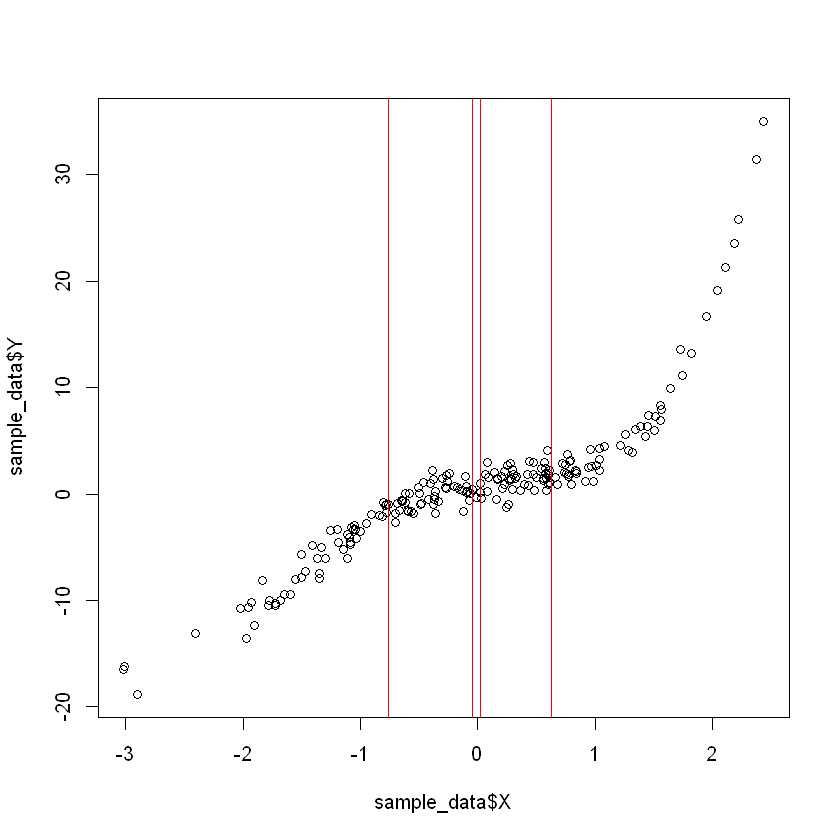

In [17]:
#generate sample and fit the model
sample_data <- DGP(n,beta)
head(sample_data,3)
lm_sample <- lm(Y~poly(X,4,raw=TRUE),data=sample_data)
summary(lm_sample)
plot(sample_data$X,sample_data$Y)
# 4 reference Points of X:
reference_points <-cbind(summary(sample_data$X)[2:5])
reference_points
abline(v=c(reference_points), lwd=0.5, lty=1, col="red")

Our reference points were the 25th and 75th percentile as well as the mean and the median of the initial sample.

### Excercise 1 a): Calculate Analytical Standard Deviation and Confidence Intervals

Based on normality assumptions and sample variance-covariance matrix:

- $ \hat{C}$ = Variance-Covariance Matrix of the estimator $\hat{ß}$
- $l_0 = (1; x_0; x^2_0; x^3_0; x^4_0)$ data vector

- $Var[\hat{f}(x_0)] = l_0^T  \hat{C}  l_0 $

Approximation for the 95%-Confidence Interval: $ \hat{y}(x_0) ± 2*SE $

1st Qu.     Median       Mean    3rd Qu. 
-1.6597234  0.9643085  0.8480313  1.7719697

[1] 0.1073457 0.1009485 0.1023066 0.1037763

lower_bound,upper_bound
<dbl>,<dbl>
-1.8744148,-1.445032
0.7624115,1.166205
0.6434181,1.052644
1.5644172,1.979522


Warning message:
"Ignoring unknown parameters: method, formula"


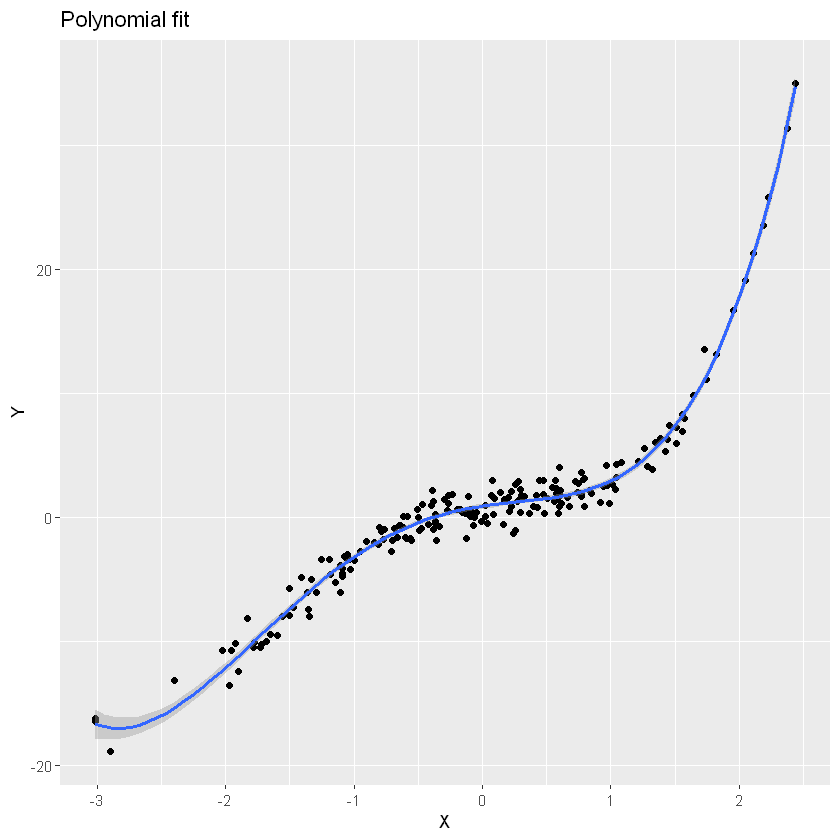

In [18]:
# Function to retrieve pointwise Standard Error
Pointwise_SE <- function(x0,lmobj){
  C_hat <- vcov(l
                m_obj)
  l_zero <- c(1,x0,x0^2,x0^3,x0^4)
  pointvar <- t(l_zero)%*%C_hat%*%l_zero
  return( sqrt(pointvar))
}
# predict y hat for all 4 reference points
y_hat_sample <- predict(lm_sample,newdata= data.frame("X"=reference_points[,1]))
y_hat_sample

SE_analytical <- rep(NA,4) # container for SE
CI_analytical <- data.frame("lower_bound"=rep(NA,4),"upper_bound"=rep(NA,4)) # container for CI approx

for (i in 1:4){
  SE <- Pointwise_SE(x0=reference_points[i],lmobj = lm_sample)
  SE_analytical[i] <- SE
  CI_analytical[i,] <- cbind(y_hat_sample[i]-2*SE,y_hat_sample[i]+2*SE)
}

SE_analytical
CI_analytical
qplot(X, Y, data=sample_data, geom=c("point", "smooth"), method="lm", formula= y ~ poly(x, 4), main = "Polynomial fit")

### Excercise 1 b): Calculate bootstrapped Confidence Intervals using the naive bootstrap quantiles

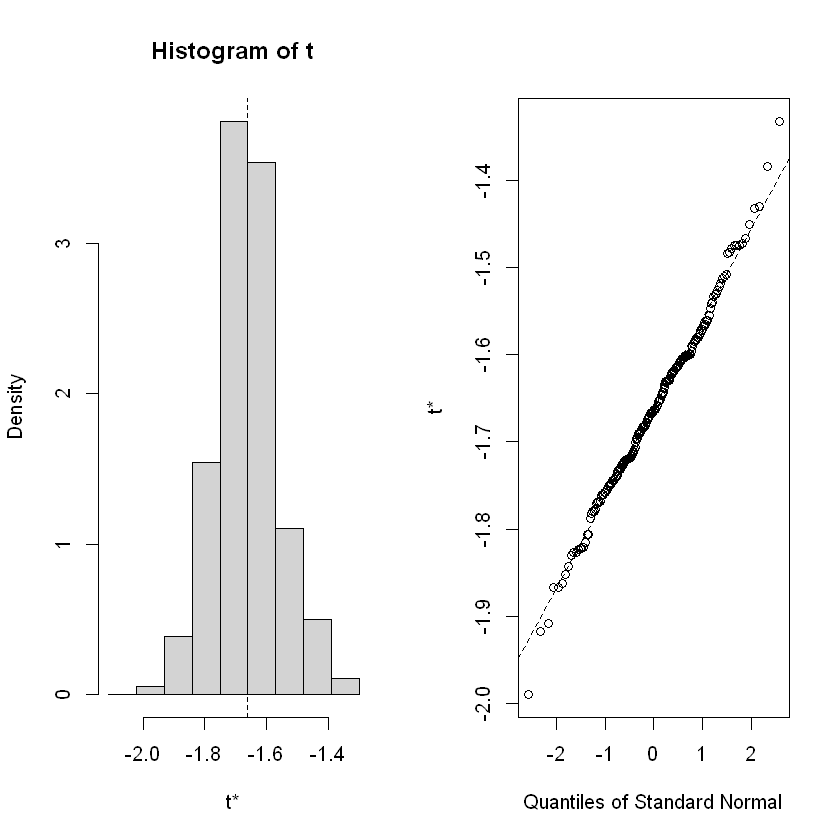

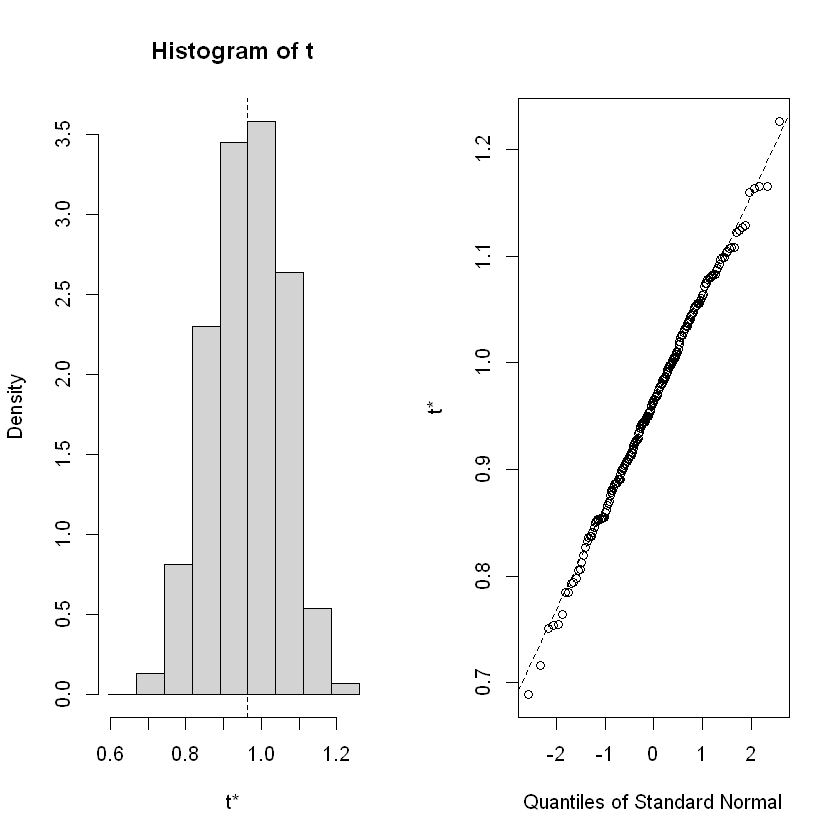

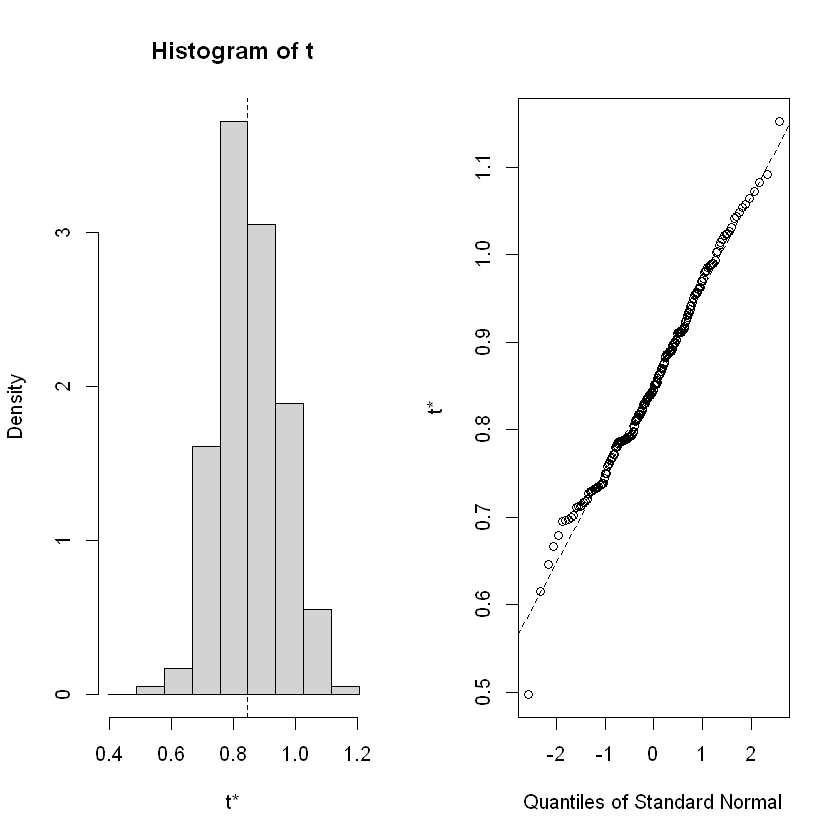

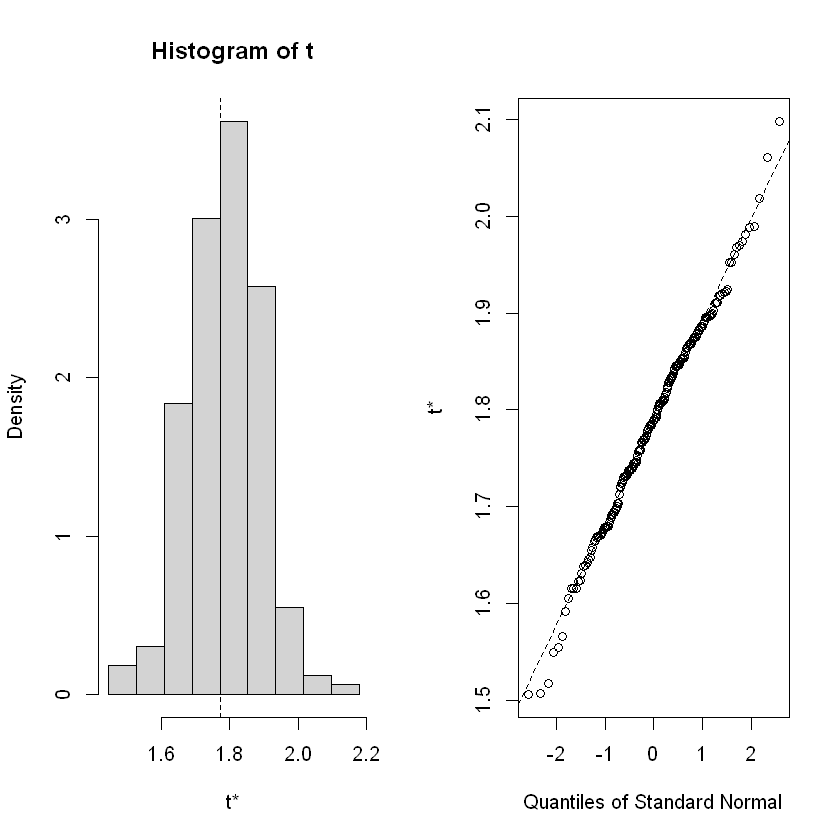

In [9]:
## Get Confidence Intervals and their coverage percentage(what we thought was wanted here) for all 4 reference points
set.seed(8)
Bootstrapped_CI_naive <- data.frame("2.5"=rep(NA,4),"97.5"=rep(NA,4)) # container for confidence intervals
Coverage_percentage <- rep(NA,4) 

for ( i in 1:4){
Getyhat <-function(data,indices){#specify bootstrap function
  d <- data[indices,]
  lm_object <- lm(Y~poly(X,4,raw=TRUE),data=d)
  y_hat_boot <- predict(lm_object,newdata= data.frame("X"=reference_points[i]))
  return(y_hat_boot)
}

yhat_boot <- boot(data=sample_data,statistic=Getyhat,R=200) #save bootstrap object
Naive_CI <- quantile(yhat_boot$t,c(0.025,0.975)) # construct naive bootstrap CI using quantiles
Inside <- Naive_CI[1] <= yhat_boot$t & yhat_boot$t <= Naive_CI[2] # COVERAGE PERCENTAGE
Coverage_percentage[i] <- length((Inside[Inside==TRUE]))/200
Bootstrapped_CI_naive[i,] <- Naive_CI #store them
plot(yhat_boot)
}

#### Naive Bootstrap quantiles.

To construct the bootstrapped Confidence Intervals we simply use the quantiles of the bootstrap distribution of the estimator $ \hat y(x_0)$ e.g. we use the middle 95% of the bootstrap estimates to form a 95% confidence interval

In [114]:
Bootstrapped_CI_naive

X2.5,X97.5
<dbl>,<dbl>
-1.8623927,-1.465833
0.7634364,1.129915
0.6945124,1.057649
1.5659960,1.981257


### Excercise 1 c): Calculate the Interval Length at four different values of X

In [91]:
length_BT <- abs(abs(Bootstrapped_CI_naive[,1])-abs(Bootstrapped_CI_naive[,2]))
length_AN <- abs(abs(CI_analytical[,1])-abs(CI_analytical[,2]))

In [92]:
length_BT

[1] 0.3965600 0.3664788 0.3631367 0.4152611

In [93]:
length_AN

[1] 0.4293827 0.4037939 0.4092263 0.4151051

We can see that the Bootstrapped CIs are slightly smaller in terms of interval length for $x_0 = (25th percentile,Mean,Median)$ while being minimally larger for $x_0 = (75th percentile)$

Intervals which correspond to the tails of the distribution (25% , 75% ) are larger than those in the middle of the distribution (mean, median).

When interpreting the Coverage Probability as the proportion of times the Bootstrapped Confidence Interval contains the $\hat y$  from different bootstrap runs the Coverage percentage is 95% for all 4 reference points -> would be surprising to see something else since we constructed the CIs with the 95% quantiles of the bootstrap distribution of the estimators. -> more interesting to see how CIs behave when resampling from the Data Generating Process in a simulation.

### Excercise 1 d) Calculate the coverage probabilities at 4 different values of X

In [101]:
Coverage_percentage

[1] 0.95 0.95 0.95 0.95

## Excercise 2 Simulation Study

### Overview:

1. Generate 100 Samples from our Data Generating Process
2. For each of those samples fit the model and calculate the analytical confidence interval for our estimator  $\hat{y}(x_0)$
3. For each sample calculate the naive bootstrap confidence interval for  $\hat{y}(x_0)$
4. Compare how often our realizations of both types of confidence intervals contain the true value $y(x_0)$ (Coverage Probability)
5. Compare the average interval length

6. Repeat step $1$-$5$ for different Data Generating Processes

In [10]:
set.seed(8)
rep <- 100
Analytical_CI_sim <- data.frame("2.5"=rep(NA,100),"97.5"=rep(NA,100))
Boot_CI_sim <- data.frame("2.5"=rep(NA,100),"97.5"=rep(NA,100))
  
# This might run a while
for (i in 1:rep){
  # DGP and new fits
  sample_data <- DGP(n,beta)
  lm_sample <- lm(Y~poly(X,4,raw=TRUE),data=sample_data)
  #Analytical CI
  y_hat_sample <- predict(lm_sample,newdata= data.frame("X"=reference_points[3]))
  SE <- Pointwise_SE(x0=reference_points[3],lmobj = lm_sample)
  CI_analytical<- cbind(y_hat_sample-2*SE,y_hat_sample+2*SE)
  Analytical_CI_sim[i,] <- CI_analytical
  ## Bootstrap CI
  Getyhat <-function(data,indices){
    d <- data[indices,]
    lm_object <- lm(Y~poly(X,4,raw=TRUE),data=d)
    y_hat_boot <- predict(lm_object,newdata= data.frame("X"=reference_points[3]))
    return(y_hat_boot)
  }
  
  yhat_boot <- boot(data=sample_data,statistic=Getyhat,R=200) #save bootstrap object
  Naive_CI_mean <- quantile(yhat_boot$t,c(0.025,0.975)) #construct CI
  Boot_CI_sim[i,] <- Naive_CI_mean
}

  
head(Boot_CI_sim,5)
head(Analytical_CI_sim,5)

,X2.5,X97.5
,<dbl>,<dbl>
1,0.6536675,1.039187
2,0.7422022,1.098198
3,0.8174276,1.251987
4,0.7618790,1.138038
5,0.8523919,1.218514


,X2.5,X97.5
,<dbl>,<dbl>
1,0.6434181,1.052644
2,0.7322583,1.118603
3,0.8147074,1.239511
4,0.7728788,1.139879
5,0.8409550,1.233234


###### Interval Length
- we can see the average length of the bootstrapped confidence intervals is slightly smaller

In [98]:
length_AN_sim <- mean(abs(abs(Analytical_CI_sim[,1])-abs(Analytical_CI_sim[,2])))
length_AN_sim

length_BT_sim <- mean(abs(abs(Boot_CI_sim[,1])-abs(Boot_CI_sim[,2]))) # there is a built in function for that 100% but couldnt find
length_BT_sim

[1] 0.402089

[1] 0.385972

##### Coverage Probability

In [99]:
x0 <- reference_points[3] # reference point for the prediction
true_y <- beta%*%c(1,x0,x0^2,x0^3,x0^4)
## COVERAGE PROBABILITY ANALYTICAL
Inside_CI_analytical <- cbind(Analytical_CI_sim$X2.5 <= rep(true_y,100) & rep(true_y,100) <= Analytical_CI_sim$X97.5) # if outside then 0
round(length(Inside_CI_analytical[Inside_CI_analytical == TRUE])/100,4)## 96% for analytical approach !!
## COVERAGE PROBABILITY BOOTSTRAP
Inside_CI_Boot <- cbind(Boot_CI_sim$X2.5 <= rep(true_y,100) & rep(true_y,100) <= Boot_CI_sim$X97.5) # if outside then 0
round(length(Inside_CI_Boot[Inside_CI_Boot == TRUE])/100,4)  ## 92% for bootstrap approach !!

[1] 0.96

[1] 0.92

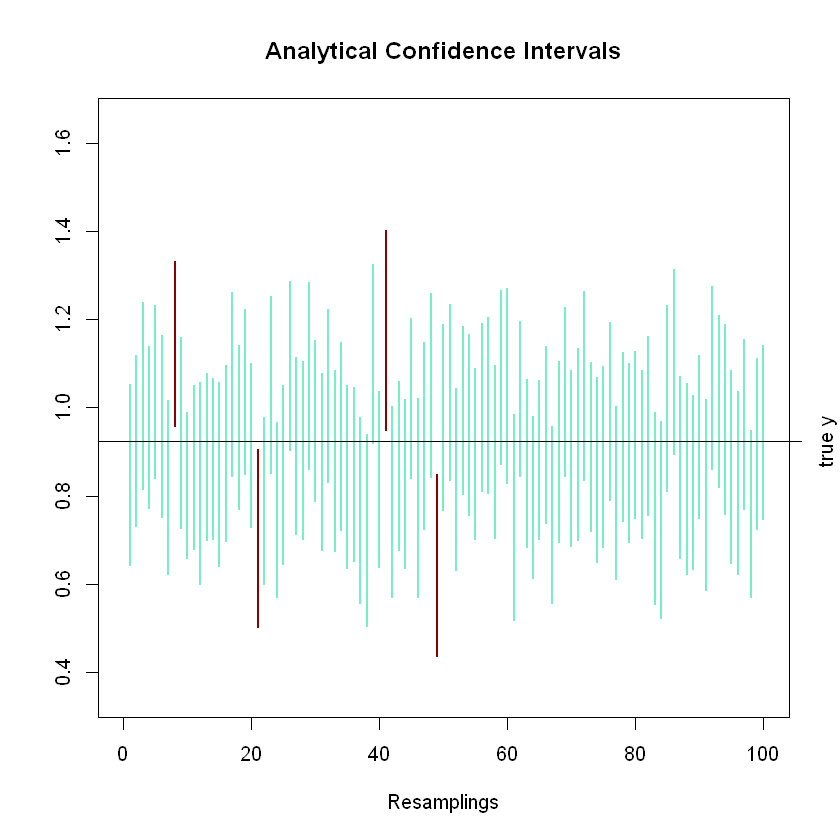

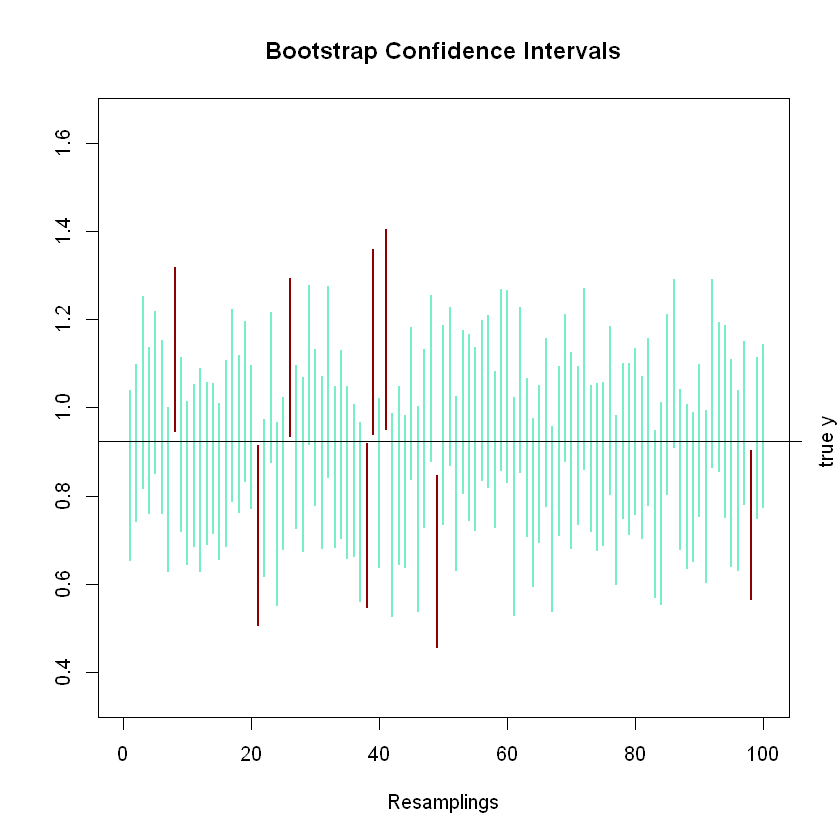

In [104]:
#Plot Analytical Confidence Intervals
nCIs <- 100
plot(x=0,y=0,type="n",xlim=c(0,nCIs),ylim= c(0.35,1.65),
                  ylab="", xlab="Resamplings", main="Analytical Confidence Intervals")
for(r in 1:nCIs){
  if(Inside_CI_analytical[r]==TRUE){
    lines(x=c(r,r), y=c(Analytical_CI_sim[r,1],Analytical_CI_sim[r,2]),
          lwd=2, col="aquamarine 2")
  }else{
    lines(x=c(r,r),y=c(Analytical_CI_sim[r,1],Analytical_CI_sim[r,2]),
          lwd=2, col="darkred")
  }
}
axis(4, at=true_y, labels = "true y")
abline(h=true_y)

#Plot Boot:
plot(x=0,y=0,type="n",xlim=c(0,nCIs),ylim= c(0.35,1.65),
     ylab="", xlab="Resamplings", main="Bootstrap Confidence Intervals")
for(r in 1:nCIs){
  if(Inside_CI_Boot[r]==TRUE){
    lines(x=c(r,r), y=c(Boot_CI_sim[r,1],Boot_CI_sim[r,2]),
          lwd=2, col="aquamarine 2")
  }else{
    lines(x=c(r,r),y=c(Boot_CI_sim[r,1],Boot_CI_sim[r,2]),
          lwd=2, col="darkred")
  }
}
axis(4, at=true_y, labels = "true y")
abline(h=true_y)

#### Results: 
- In 200 realizations of the confidence intervals for the point predictions $\hat y(x_0)$ using the analytical approach, 4 did not contain the true y at that point. Coverage Probability: 96%
- In 200 realizations of the confidence intervals for $\hat y(x_0)$ using the bootstrap approach, 8 did not contain the true y. Coverage Probability: 92 % 